# Sheet 5

In [26]:
import os
import numpy as np
import pandas as pd

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [2]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [ ]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

In [185]:
# Evaluate the perforamnce of the LLM on the train and test set
# Train with logistic regression without regularization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000, penalty=None)
clf.fit(acts_train, labels_train)
train_acc = accuracy_score(labels_train, clf.predict(acts_train))
test_acc = accuracy_score(labels_test, clf.predict(acts_test))
print(f"Train accuracy: {train_acc}, Test accuracy: {test_acc}")


Train accuracy: 1.0, Test accuracy: 1.0


In [ ]:
# Now train separate models for each dataset and evaluate the performance
# of the model on the test set


for dataset_name in dataset_names:
    data_1 = DataManager()
    data_1.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    acts_test, labels_test = dm.get('val')
    clf = LogisticRegression(penalty=None, max_iter=100)
    clf.fit(acts_train, labels_train)
    test_acc = accuracy_score(labels_test, clf.predict(acts_test))
    print(f"Dataset: {dataset_name}, Test accuracy: {test_acc}")

Dataset: cities, Test accuracy: 1.0
Dataset: neg_cities, Test accuracy: 1.0
Dataset: sp_en_trans, Test accuracy: 1.0
Dataset: neg_sp_en_trans, Test accuracy: 1.0


### (b)

In [ ]:
# Now observe how LR trained on one set persomes on another set
# Train with logistic regression without regularization

dm_reg = DataManager()
dm_reg.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm_reg.get('train') # train set
acts_test, labels_test = dm_reg.get('val')

clf_reg = LogisticRegression(max_iter=100)
clf_unreg = LogisticRegression(max_iter=100, penalty=None)
clf_reg.fit(acts_train, labels_train)
clf_unreg.fit(acts_train, labels_train)

# Test performance on the other 3 datasets
for dataset_name in dataset_names[1:]:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    acts_test, labels_test = dm.get('val')
    test_acc_reg = accuracy_score(labels_test, clf_reg.predict(acts_test))
    test_acc_unreg = accuracy_score(labels_test, clf_unreg.predict(acts_test))
    print(f"Dataset: {dataset_name}, Test accuracy with regularization: {test_acc_reg}, Test accuracy without regularization: {test_acc_unreg}")


Dataset: neg_cities, Test accuracy with regularization: 0.5133333333333333, Test accuracy without regularization: 0.5133333333333333
Dataset: sp_en_trans, Test accuracy with regularization: 1.0, Test accuracy without regularization: 0.9436619718309859
Dataset: neg_sp_en_trans, Test accuracy with regularization: 0.4788732394366197, Test accuracy without regularization: 0.4788732394366197


This shows some quite interesting results:
- First, we see that the model has no understanding of the negated statements. This is shown by the ~50% accuracy, which is equivalent here to randomly guessing.
- Second, we see that the model does generalise well to the spanish word datasets, which is also quite interesting, given the complete difference in the topics.
- Third, we see that regularisation improves the accuracy score when evaluating on the spanish to english set

In [191]:
# Now we try training on both the cities and negated cities datasets and evaluate on the spanish words datasets
dm_cities = DataManager()
dm_cities.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
dm_cities.add_dataset("neg_cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm_cities.get('train') # train set
acts_test, labels_test = dm_cities.get('val')

clf_full = LogisticRegression(max_iter=100)
clf_full.fit(acts_train, labels_train)

# Now test on the spanish words dataset
for i in range(2):
    dm = DataManager()
    dm.add_dataset(dataset_names[i+2], "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    acts_test, labels_test = dm.get('val')
    test_acc_full = accuracy_score(labels_test, clf_full.predict(acts_test))
    print(f"Dataset: {dataset_names[i+2]}, Test accuracy with regularization: {test_acc_full}")

Dataset: sp_en_trans, Test accuracy with regularization: 1.0
Dataset: neg_sp_en_trans, Test accuracy with regularization: 0.9859154929577465


Now, after training on both the cities and negated cities datasets, the LLM generalises well to other datasets of the same format.

## 3 Log-sum-exp and soft(arg)max


### (a)

In [243]:
lam = 0.5

def soft_arg_max_k(x, k, lam):
    return np.sum(np.exp(lam*x[k])) / np.sum(np.exp(lam*x), axis=0)

sig_1 = np.array([1, 2, 3])
sig_2 = np.array([11, 12, 13])
sig_3 = np.array([10, 20, 30])

softmaxs_1 = [soft_arg_max_k(sig_1, i, lam) for i in range(3)]
softmaxs_2 = [soft_arg_max_k(sig_2, i, lam) for i in range(3)]
softmaxs_3 = [soft_arg_max_k(sig_3, i, lam) for i in range(3)]

print(softmaxs_1)
print(softmaxs_2)
print(softmaxs_3)

# Observe sigma 1 and sigma 2  give the same soft(arg)max values
np.round(softmaxs_1, 10) == np.round(softmaxs_2, 10)

[0.1863237232258476, 0.30719588571849843, 0.506480391055654]
[0.1863237232258476, 0.3071958857184984, 0.506480391055654]
[4.509404123635488e-05, 0.006692549116589287, 0.9932623568421743]


array([ True,  True,  True])

We see the same softmax values for a fixed offset, this can be proved more generally.
For the scaling, we see that clearly this is not invariant, shown by counterexample.

Consider soft(arg)max($\mathbb{\sigma + \delta}; \lambda)_k$
$ = \frac{\text{exp}(\lambda (\sigma_k + \delta)}{\sum_{j}{\text{exp}(\lambda (\sigma_j + \delta))}}$

$ = \frac{\text{exp}(\lambda \delta)\text{exp}(\lambda\sigma_k)}{\sum_{j}{\text{exp}(\lambda \delta)\text{exp}(\lambda \sigma_j)}}$

$ = \frac{\text{exp}(\lambda \sigma_k)}{\sum_{j}{\text{exp}(\lambda \sigma_j )}}$
 = soft(arg)max($\mathbb{\sigma}; \lambda)_k$

### (b)

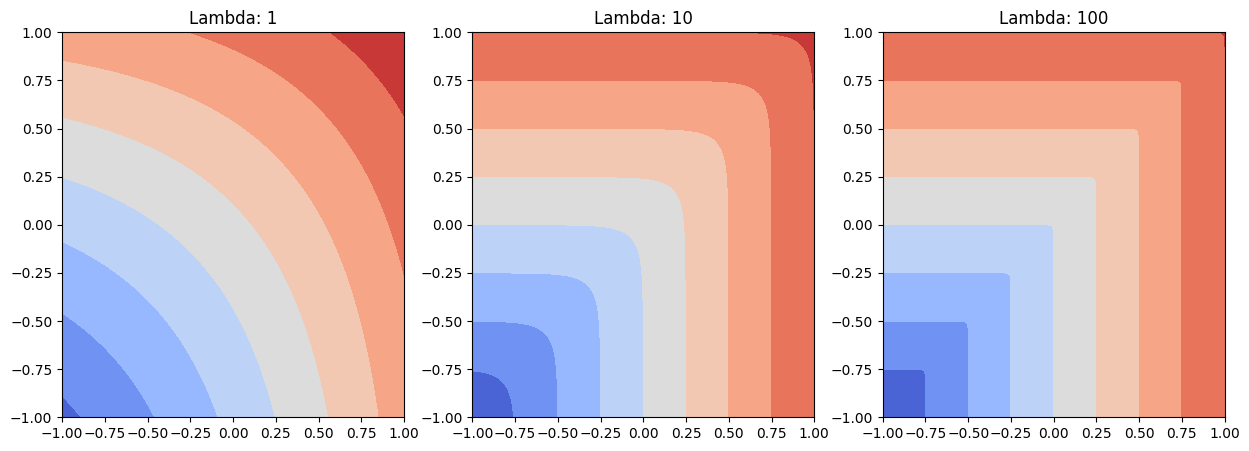

In [285]:
# Make a 2d contour plot of lse(sigma_1, sigma_2, lambda) for lambda in {1, 10, 100}, sigma_1, 2 in range [-1,1]

import matplotlib.pyplot as plt
from matplotlib import cm

sig_1 = np.linspace(-1, 1, 100)
sig_2 = np.linspace(-1, 1, 100)
lam = [1, 10, 100]
X, Y = np.meshgrid(sig_1, sig_2)
Z = np.zeros((100, 100, 3))

for i in range(100):
    for j in range(100):
        for k in range(3):
            Z[i, j, k] = 1/lam[k] * np.log(np.exp(lam[k]*sig_1[i]) + np.exp(lam[k]*sig_2[j]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].contourf(X, Y, Z[:, :, i], cmap=cm.coolwarm)
    ax[i].set_title(f"Lambda: {lam[i]}")
plt.show()



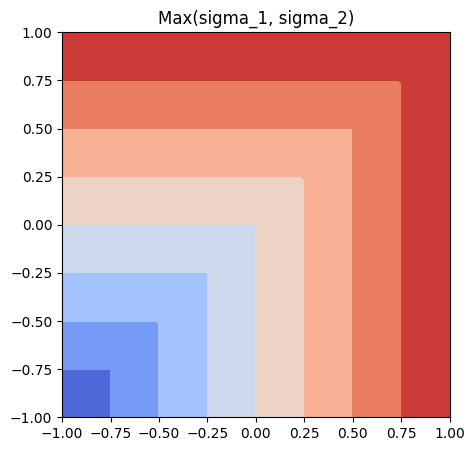

In [287]:
# compare to controur plot of max(sigma_1, sigma_2) for sigma_1, 2 in range [-1,1]

Z = np.zeros((100, 100, 3))
for i in range(100):
    for j in range(100):
        for k in range(3):
            Z[i, j, k] = max(sig_1[i], sig_2[j])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(X, Y, Z[:, :, 0], cmap=cm.coolwarm)
ax.set_title(f"Max(sigma_1, sigma_2)")
plt.show()

We see that for $\lambda \rightarrow \infty $ the lse approaches the max function

### (c)

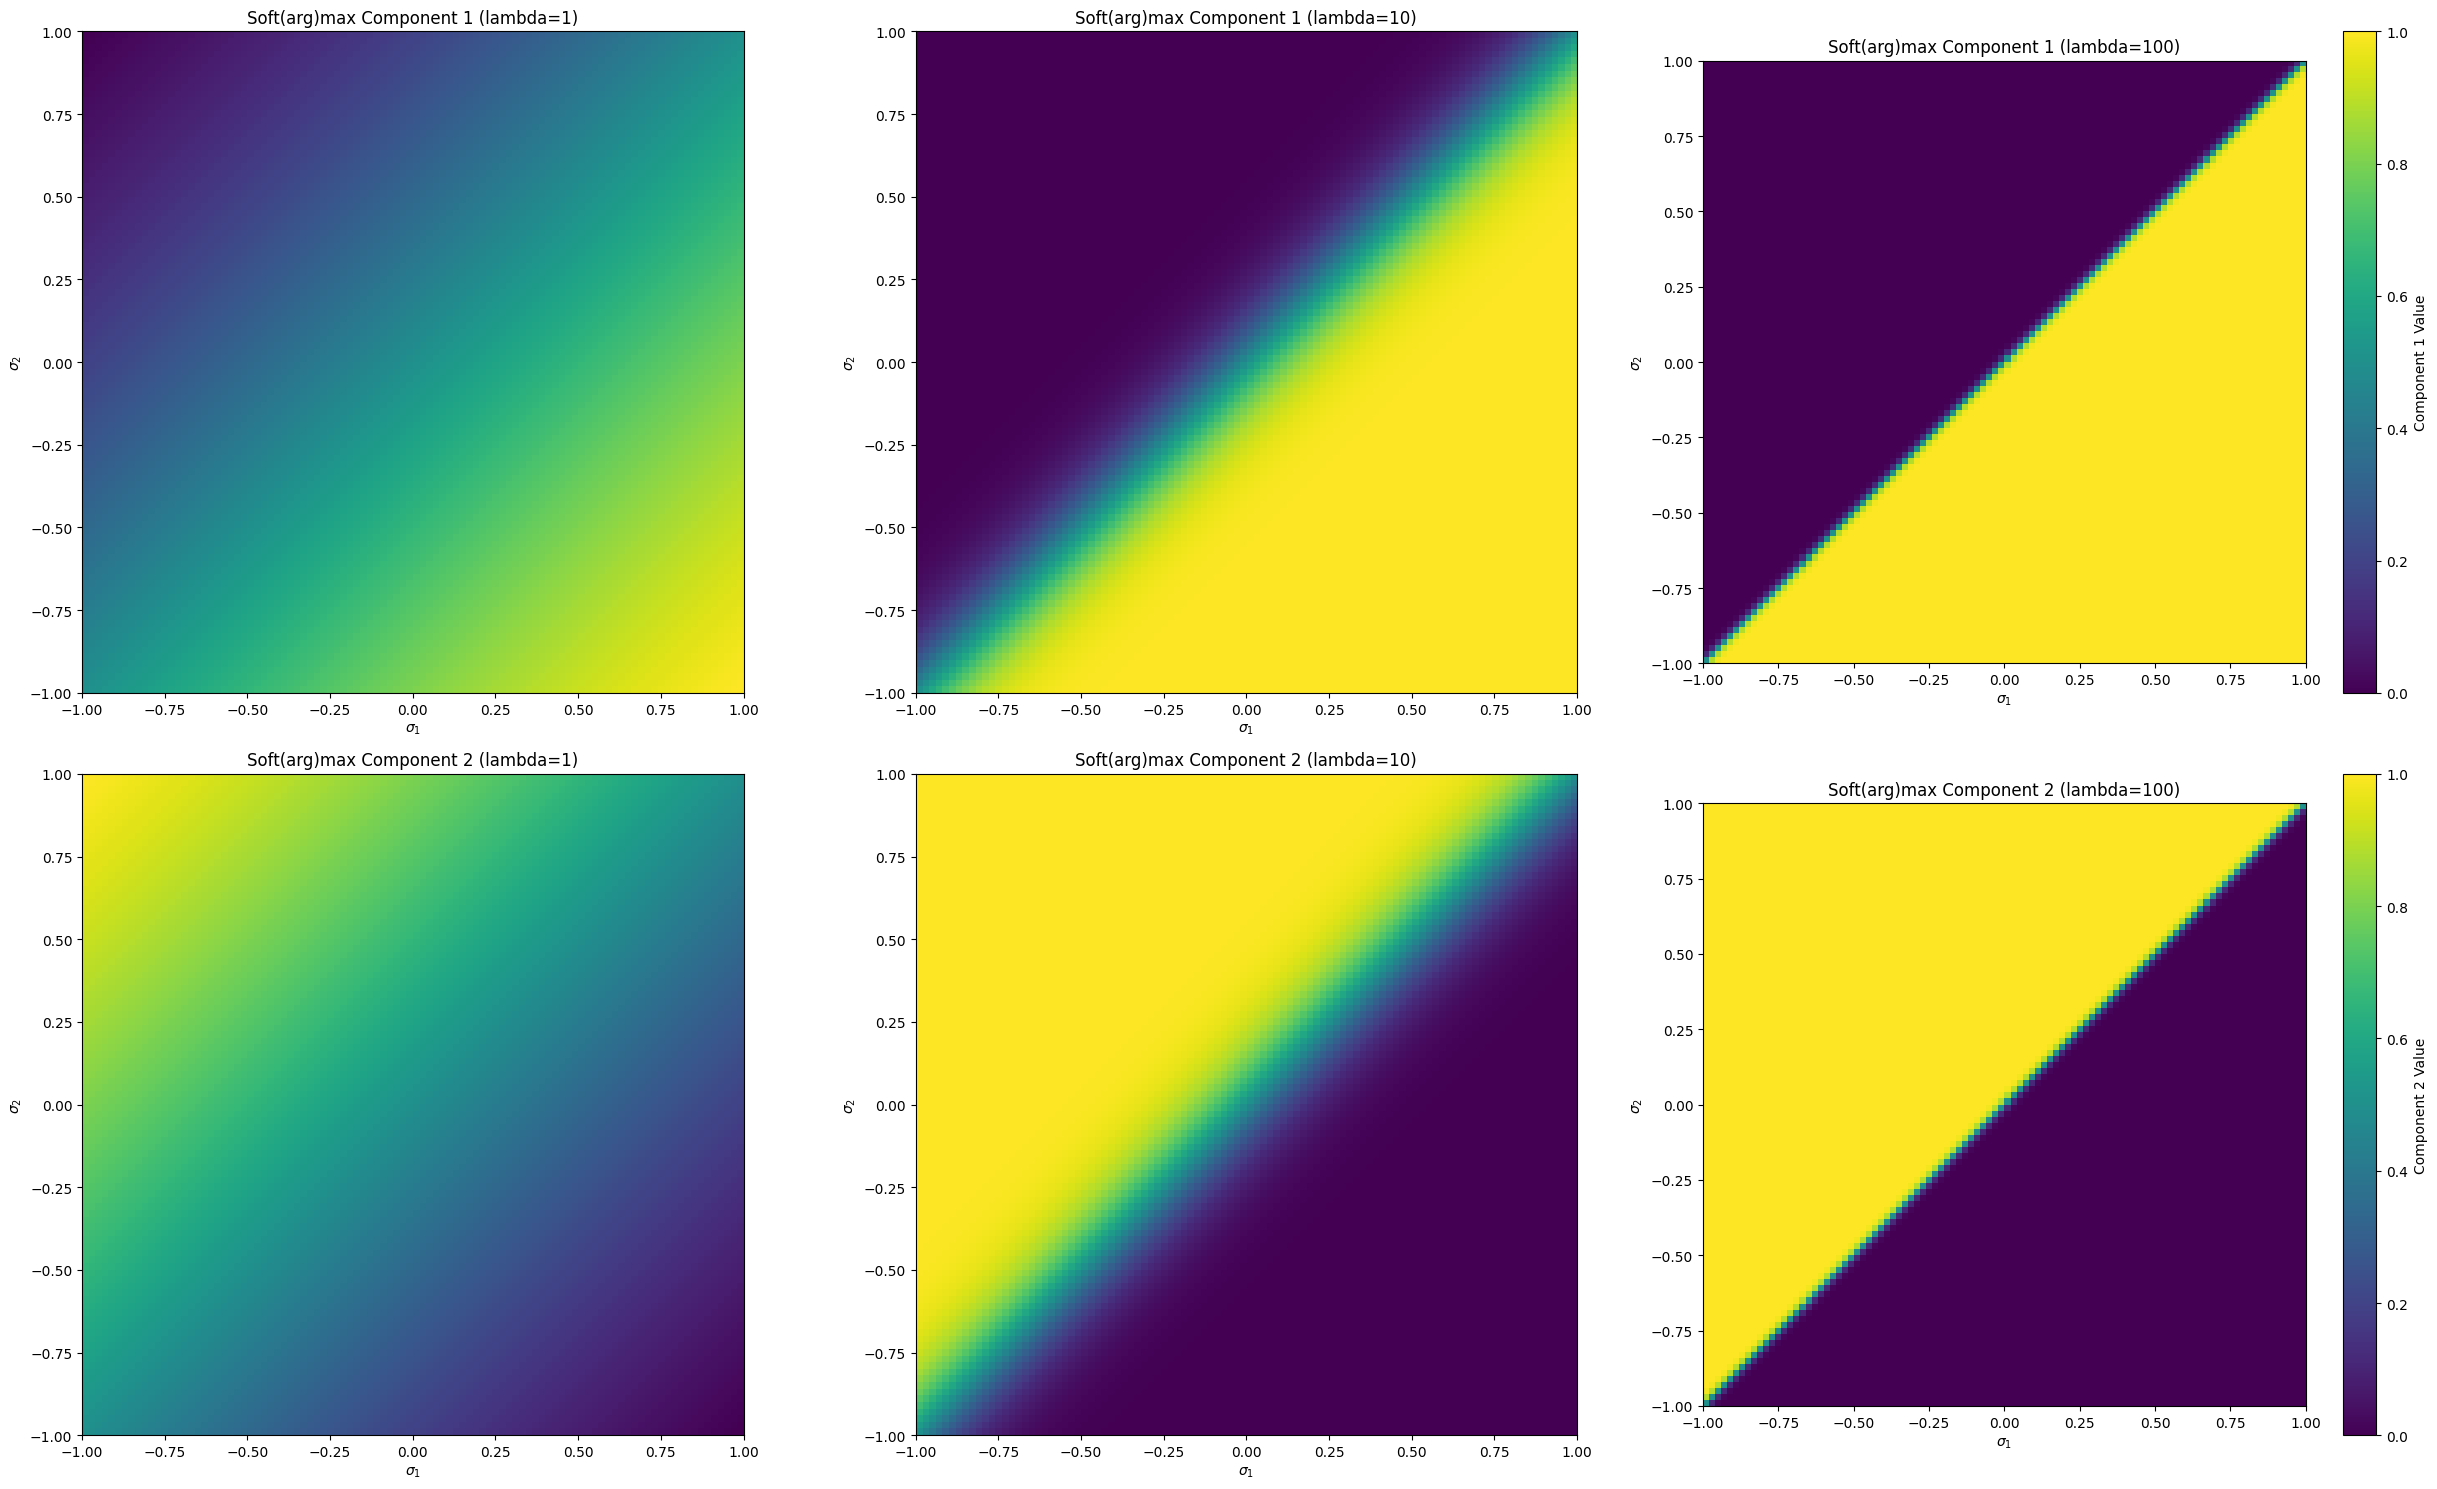

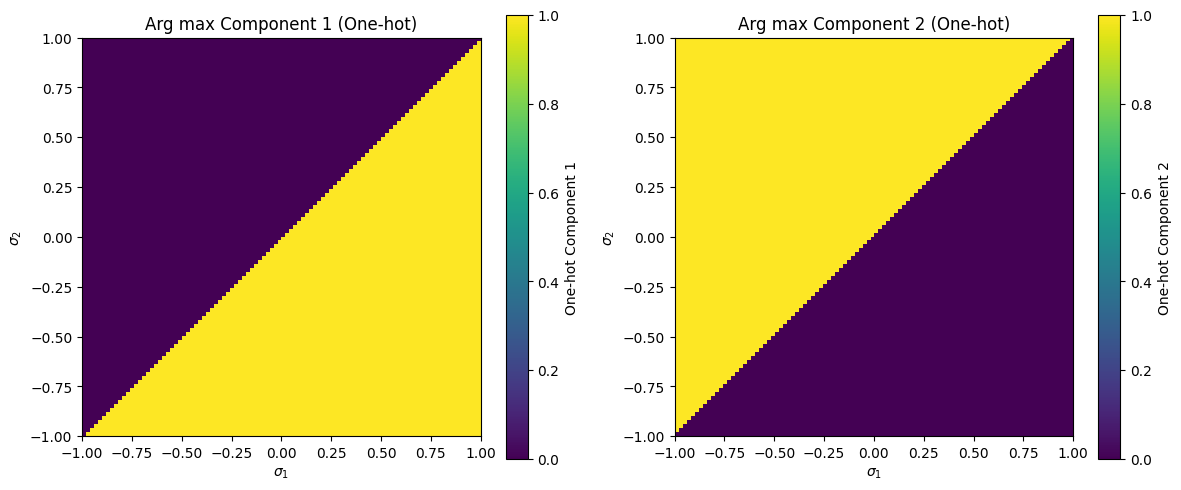

In [283]:
import numpy as np
import matplotlib.pyplot as plt

# Generate grid
sigma1 = np.linspace(-1, 1, 100)
sigma2 = np.linspace(-1, 1, 100)
sigma1, sigma2 = np.meshgrid(sigma1, sigma2)

# Define softargmax function
def softargmax(sigma1, sigma2, lam):
    exp1 = np.exp(lam * sigma1)
    exp2 = np.exp(lam * sigma2)
    denom = exp1 + exp2
    return exp1 / denom, exp2 / denom

# Define lambda values
lam_values = [1, 10, 100]

# Plot soft(arg)max components for each lambda value using subplots
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
for i, lam in enumerate(lam_values):
    soft1, soft2 = softargmax(sigma1, sigma2, lam)
    
    
    # Soft(arg)max Component 1
    im1 = ax[0,i].imshow(soft1, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    ax[0,i].set_title(f'Soft(arg)max Component 1 (lambda={lam})')
    ax[0,i].set_xlabel(r'$\sigma_1$')
    ax[0,i].set_ylabel(r'$\sigma_2$')
    
    
    # Soft(arg)max Component 2
    im2 = ax[1,i].imshow(soft2, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    ax[1,i].set_title(f'Soft(arg)max Component 2 (lambda={lam})')
    ax[1,i].set_xlabel(r'$\sigma_1$')
    ax[1,i].set_ylabel(r'$\sigma_2$')
    
plt.colorbar(im1, ax=ax[0,2], label='Component 1 Value')
plt.colorbar(im2, ax=ax[1,2], label='Component 2 Value')
plt.tight_layout()
plt.show()

# Arg max as one-hot vectors (shared across all lambda values)
argmax1 = (sigma1 > sigma2).astype(float)
argmax2 = (sigma2 > sigma1).astype(float)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Arg max Component 1
im1 = ax[0].imshow(argmax1, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
ax[0].set_title('Arg max Component 1 (One-hot)')
ax[0].set_xlabel(r'$\sigma_1$')
ax[0].set_ylabel(r'$\sigma_2$')
plt.colorbar(im1, ax=ax[0], label='One-hot Component 1')

# Arg max Component 2
im2 = ax[1].imshow(argmax2, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
ax[1].set_title('Arg max Component 2 (One-hot)')
ax[1].set_xlabel(r'$\sigma_1$')
ax[1].set_ylabel(r'$\sigma_2$')
plt.colorbar(im2, ax=ax[1], label='One-hot Component 2')

plt.tight_layout()
plt.show()


## 4 Linear regions of MLPs

In [51]:
import torch 
import torch.nn as nn

In [82]:
# Implement a shallow model with a single hidden layer of 20 neurons

class ShallowModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_dim=20):
        super(ShallowModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [291]:
# Initialize model
shallow_model = ShallowModel()
print(shallow_model)

# Calculate the number of parameters
shallow_params = sum(p.numel() for p in shallow_model.parameters())
print(f"Number of parameters in the shallow model: {shallow_params}")


ShallowModel(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)
Number of parameters in the shallow model: 81


To calculate number of parameters, consider the number of weights and biases needed.

Here $x \in \mathbb{R}^2$ : 2 * 20 input weights

Each Neuron has a bias: 20 biases

$y \in \mathbb{R}$ : 1 * 20 output weights

1 output bias

So 81 paramters

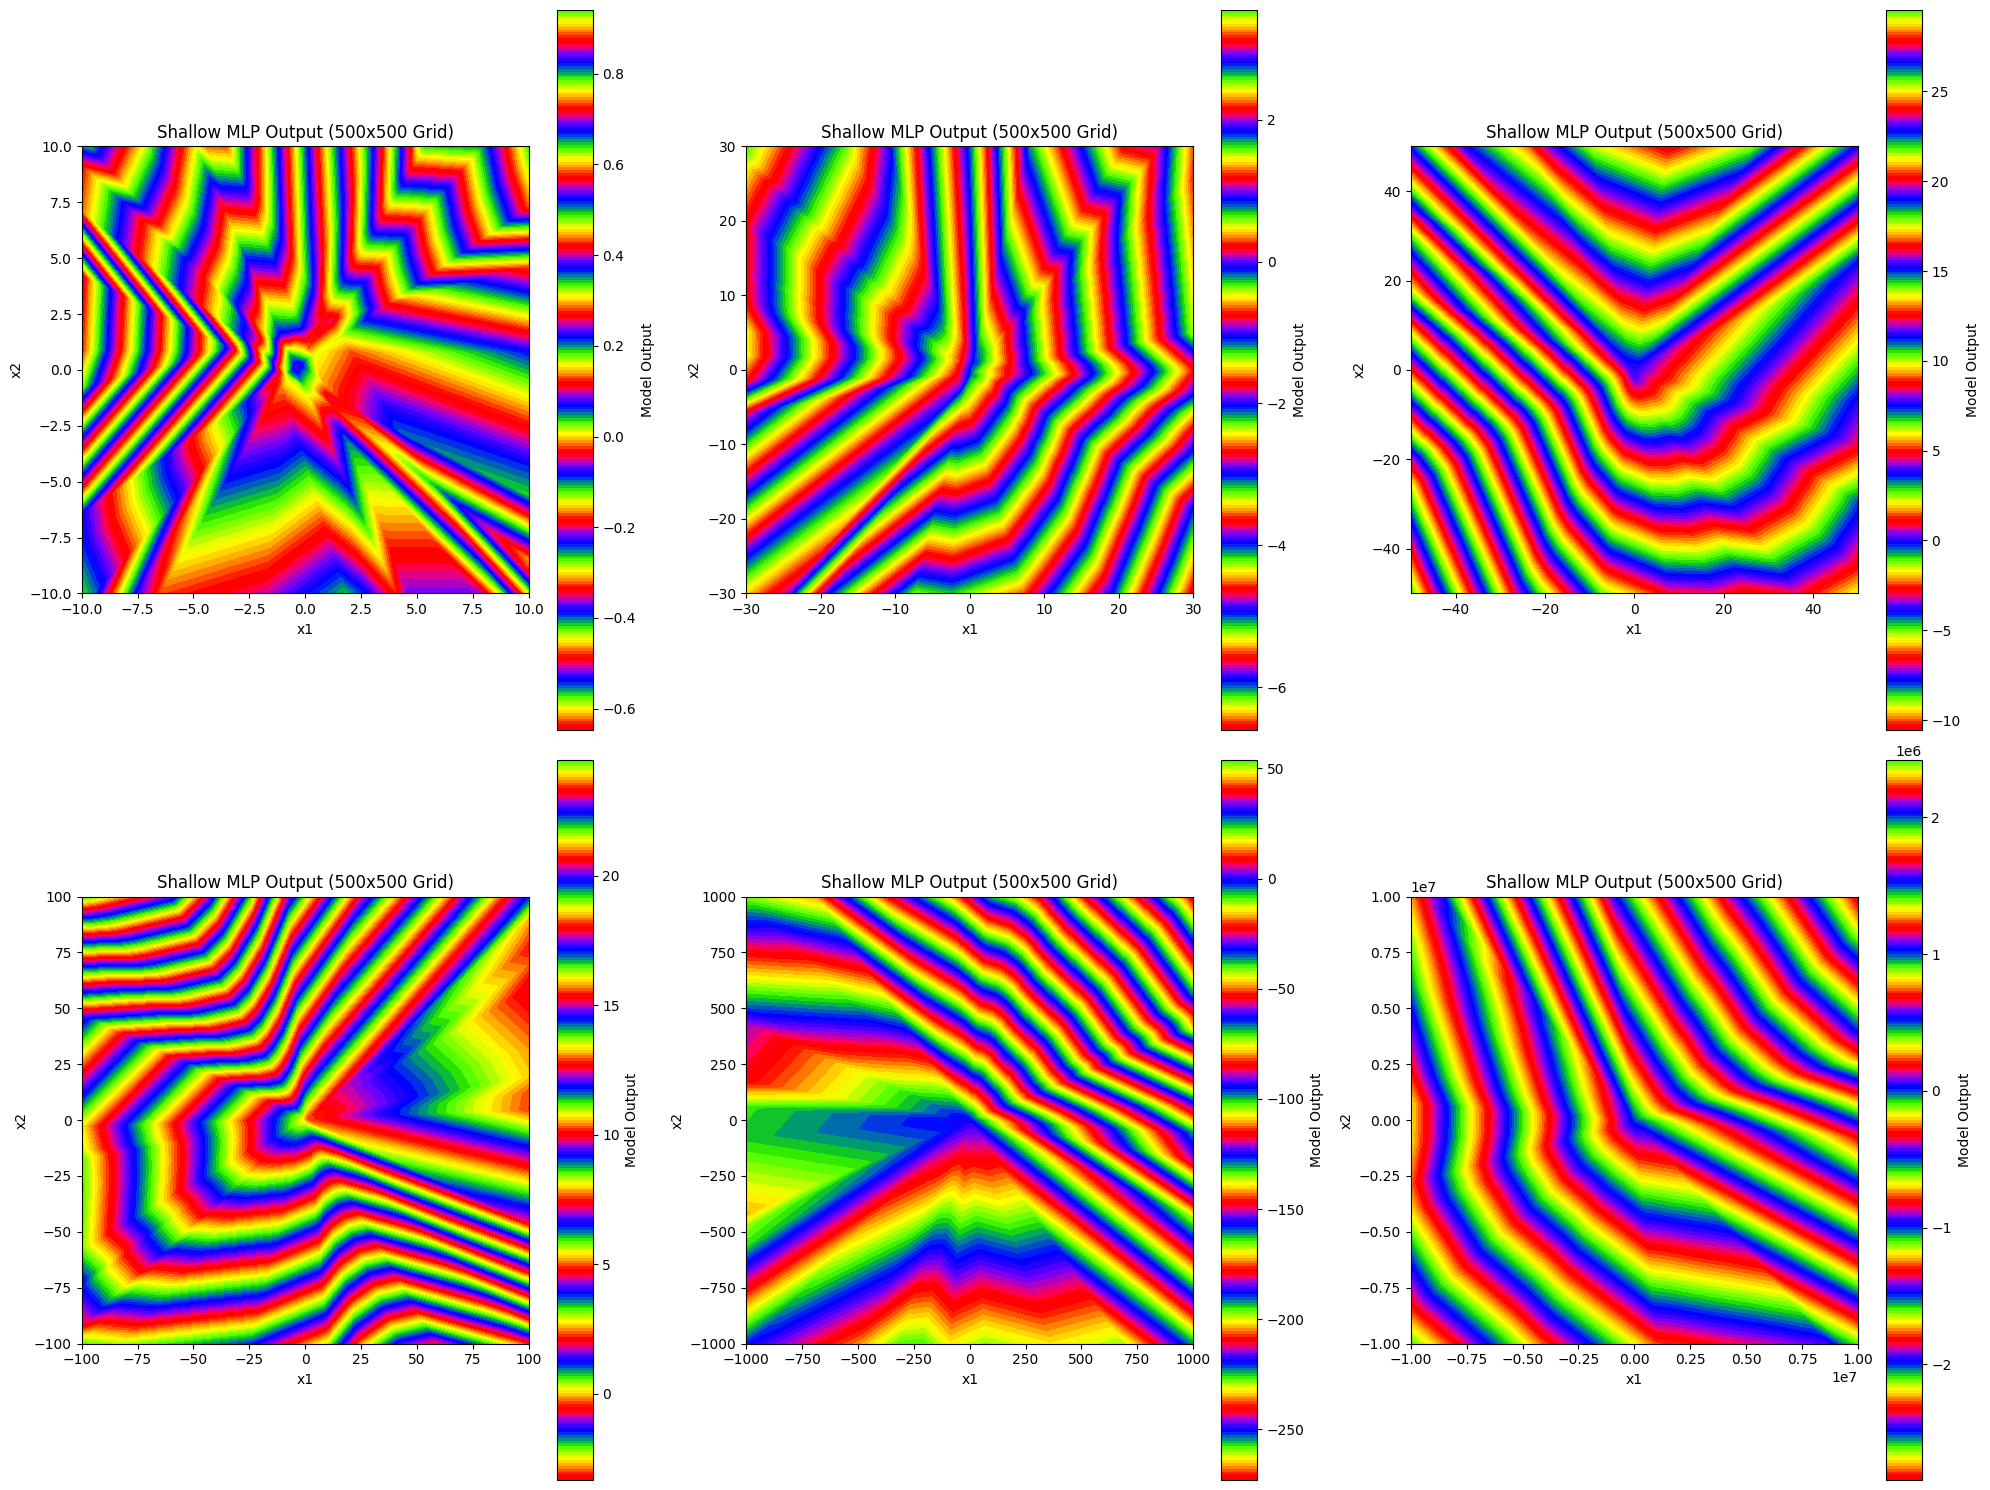

In [310]:
sizes = [10, 30, 50, 100, 1000, 10000000]

fig, ax = plt.subplots(2, 3, figsize=(20, 15))
for i, size in enumerate(sizes):
    shallow_model = ShallowModel()
    x1 = np.linspace(-size, size, 500)
    x2 = np.linspace(-size, size, 500)
    grid_x, grid_y = np.meshgrid(x1, x2)
    grid_points = np.stack([grid_x.flatten(), grid_y.flatten()], axis=-1)
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Compute outputs
    shallow_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = shallow_model(grid_tensor).numpy()

    # Reshape outputs to match grid
    outputs = outputs.reshape(500, 500)

    # Visualize outputs
    im1 = ax[int(i/3), i%3].imshow(outputs, extent=(-size, size, -size, size), origin='lower', cmap='prism')
    #im1 = ax[int(i/7), i%3].imshow(outputs, extent=(-size, size, -size, size), origin='lower', cmap='viridis')
    fig.colorbar(im1, label="Model Output")
    ax[int(i/3), i%3].set_title("Shallow MLP Output (500x500 Grid)")
    ax[int(i/3), i%3].set_xlabel("x1")
    ax[int(i/3), i%3].set_ylabel("x2")
    fig.tight_layout()
plt.tight_layout()
plt.show()


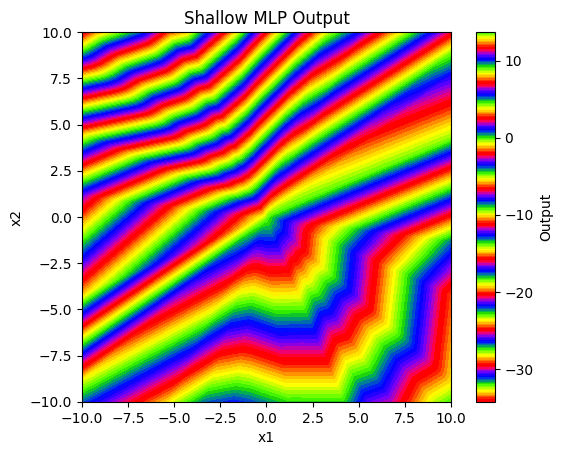

In [316]:
model4 = ShallowModel()
# Generate grid points
size = 100
x1 = np.linspace(-size, size, 500)
x2 = np.linspace(-size, size, 500)
x1, x2 = np.meshgrid(x1, x2)
grid = np.stack([x1.ravel(), x2.ravel()], axis=1)  # Shape (250000, 2)

# Convert grid to tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Compute model output
with torch.no_grad():
    output = model4(grid_tensor).numpy().reshape(500, 500)

# Visualize output
plt.imshow(output, extent=(-10, 10, -10, 10), origin='lower', cmap='prism')
plt.colorbar(label='Output')
plt.title('Shallow MLP Output')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


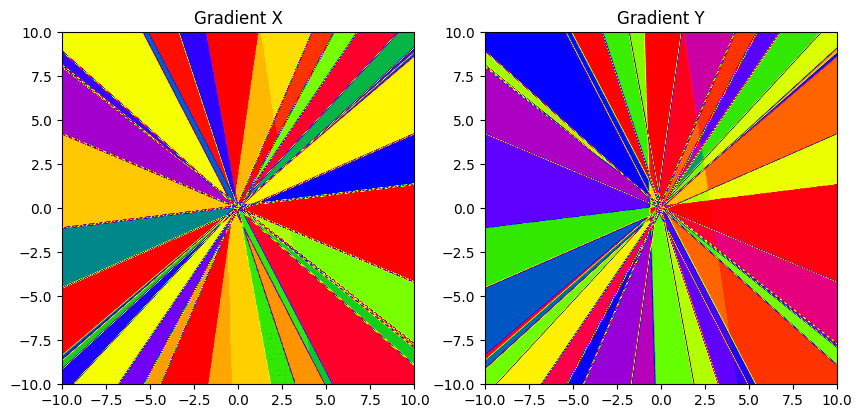

In [317]:
# Use numpy.gradient to compute spatial gradient of network as an image
# Visualise components using prism colormap

grad = np.gradient(output)
grad_x = grad[0]
grad_y = grad[1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(grad_x,extent=(-10, 10, -10, 10), cmap='prism')
ax[0].set_title('Gradient X')
ax[1].imshow(grad_y, extent=(-10, 10, -10, 10), cmap='prism')
ax[1].set_title('Gradient Y')
plt.show()

Regions form around centre all regions radiate outwards to surround the centre

In [155]:
# Now implement a deep model with 4 hidden layers of 5 neurons each
class DeepModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_dim=5):
        super(DeepModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)

        return x

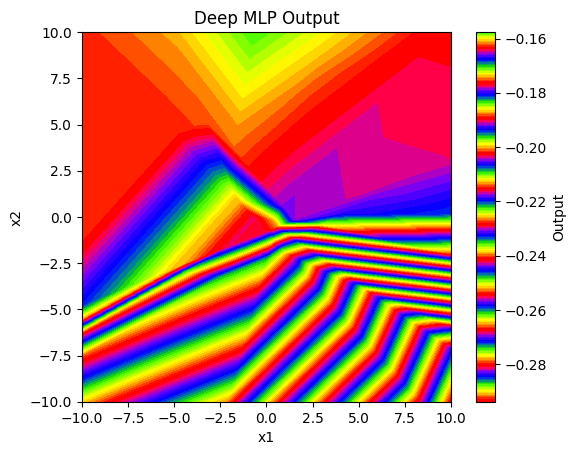

In [320]:
model_deep = DeepModel()
# Generate grid points
size = 10
x1 = np.linspace(-size, size, 500)
x2 = np.linspace(-size, size, 500)
x1, x2 = np.meshgrid(x1, x2)
grid = np.stack([x1.ravel(), x2.ravel()], axis=1)  # Shape (250000, 2)

# Convert grid to tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Compute model output
with torch.no_grad():
    output = model_deep(grid_tensor).numpy().reshape(500, 500)

# Visualize output
plt.imshow(output, extent=(-size, size, -size, size), origin='lower', cmap='prism')
plt.colorbar(label='Output')
plt.title('Deep MLP Output')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

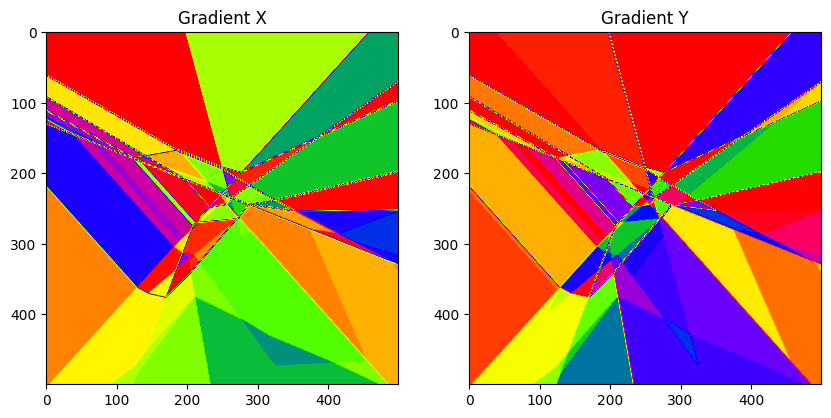

In [321]:
# Use numpy.gradient to compute spatial gradient of network as an image
# Visualise components using prism colormap

grad = np.gradient(output)
grad_x = grad[0]
grad_y = grad[1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(grad_x, cmap='prism')
ax[0].set_title('Gradient X')
ax[1].imshow(grad_y, cmap='prism')
ax[1].set_title('Gradient Y')
plt.show()

Larger regions, more complex gradient flow lines